
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [30]:
import pandas as pd
import numpy as np

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [31]:
embedding_model = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec')

In [32]:
df = pd.read_csv('../datasets/b2w_preprocessed.csv')

In [33]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

71516 instancias, 2 classes


In [34]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [35]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

In [36]:
texts = df.review_text
labels = df.rating

In [37]:
def get_average_embedding(text):
    words = str(text).split()
    embeddings = [embedding_model[word] for word in words if word in embedding_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

In [38]:
X_embeddings = np.array([get_average_embedding(text) for text in texts])

In [39]:
print(f'{X_embeddings.shape[0]} sentenças, {X_embeddings.shape[1]} dimensoes')

71516 sentenças, 300 dimensoes


In [40]:
# 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.05

# 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-4

K_FOLDS = 10
EPOCHS = 5
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 32
#CHECKPOINT = ModelCheckpoint(filepath='../weights/fast_text_mlp_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]
VERBOSE=1

In [41]:
model = Sequential()
model.add(Input(300,)),
model.add(Dense(24, activation='relu')),
model.add(Dropout(DROPOUT)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 24)                7224      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Funcao responsavel por carregar os pesos do treinamento anterior extensão .hdf5
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [43]:
# Acoplando os pesos ao modelo
fast_text_mlp_hdf5_weight_path = '../weights/fast_text_mlp_weights.hdf5'
model = load_weights_from_hdf5(model, fast_text_mlp_hdf5_weight_path)

In [44]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [45]:
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

In [46]:
fold = 0

train_loss_history = []
train_accuracies = []
train_f1_scores = []

val_f1_scores = []
val_accuracies = []
for train_idx, val_idx in skf.split(X_embeddings, labels):
    fold += 1
    print(f'fold ---> {fold}')
    
    X_train, X_val = X_embeddings[train_idx], X_embeddings[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        verbose=VERBOSE, 
        batch_size=BATCH_SIZE,  
        epochs=EPOCHS,
        validation_data=(X_train, y_train),
        callbacks=CALLBACKS
    )
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracies.append(model_history.history['accuracy'])
    
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    
    train_f1_score = f1_score(y_train, y_pred_train)
    train_f1_scores.append(train_f1_score)
    
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    val_fold_f1_score = f1_score(y_val, y_pred)
    val_f1_scores.append(val_fold_f1_score)
    
    val_accuracy = accuracy_score(y_val, y_pred)
    val_accuracies.append(val_accuracy)

print('-'*80)
print(f'mean_train_loss = {round(np.mean(train_loss_history),4)}')
print(f'mean_train_accuracy = {round(np.mean(train_accuracies),4)}')
print(f'mean_train_f1_score = {round(np.mean(train_f1_scores),4)}')
print('-'*40)
print(f'mean_val_accuracy = {round(np.mean(val_accuracies),4)}')
print(f'mean_val_f1_score = {round(np.mean(val_f1_scores), 4)}')

fold ---> 1
Epoch 1/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1797 - accuracy: 0.9315 - val_loss: 0.1734 - val_accuracy: 0.9349
Epoch 2/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1797 - accuracy: 0.9313 - val_loss: 0.1702 - val_accuracy: 0.9360
Epoch 3/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1786 - accuracy: 0.9333 - val_loss: 0.1702 - val_accuracy: 0.9362
Epoch 4/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1778 - accuracy: 0.9320 - val_loss: 0.1715 - val_accuracy: 0.9359
Epoch 5/5
224/224 [==============================] - 0s 698us/step
fold ---> 2
Epoch 1/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1771 - accuracy: 0.9326 - val_loss: 0.1698 - val_accuracy: 0.9356
Epoch 2/5
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1771 - accuracy: 0.9330 - val_loss: 0.1683 - val_accuracy: 0.9380
Epoch 3/5
2012/2012 [==============================

In [47]:
def plot_k_folds_metrics(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.show()
    
def plot_train_f1_score(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list

    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Train {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Train {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0) 
    plt.show()
    
def plot_validation_graphs(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list

    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Validation {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Validation {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0) 
    plt.show()

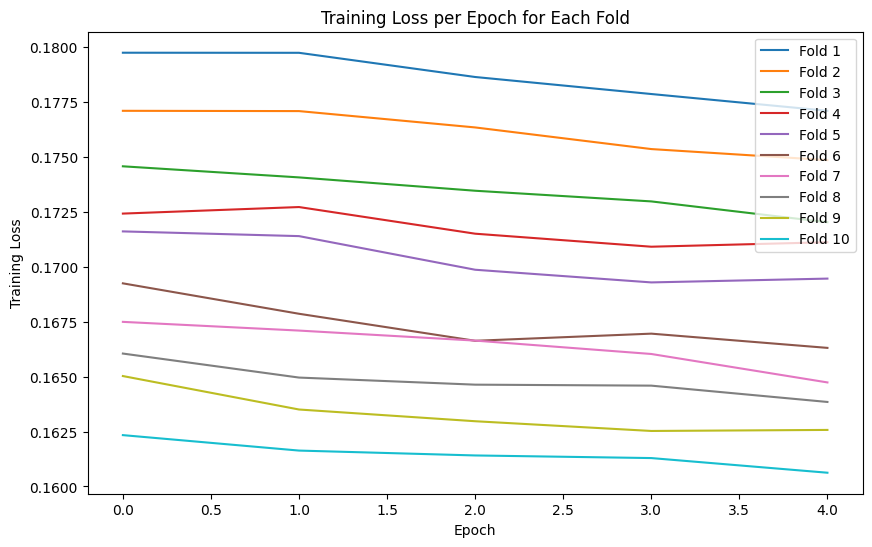

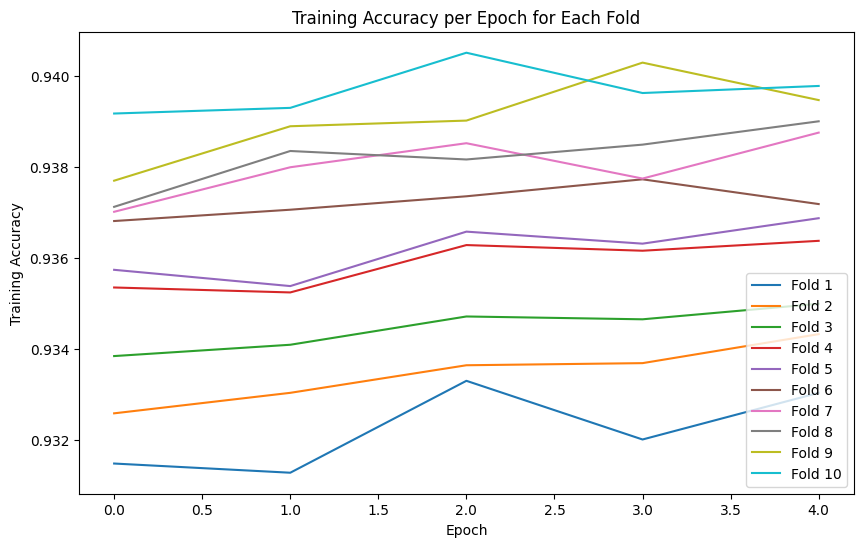

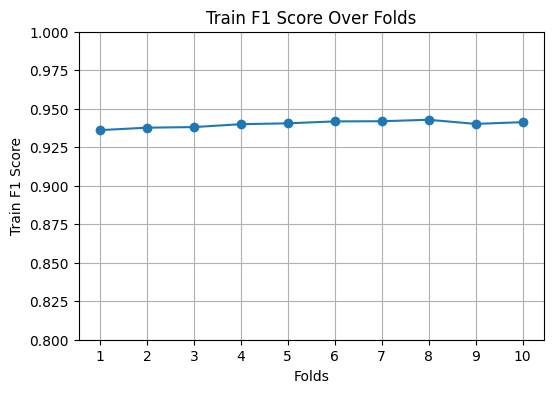

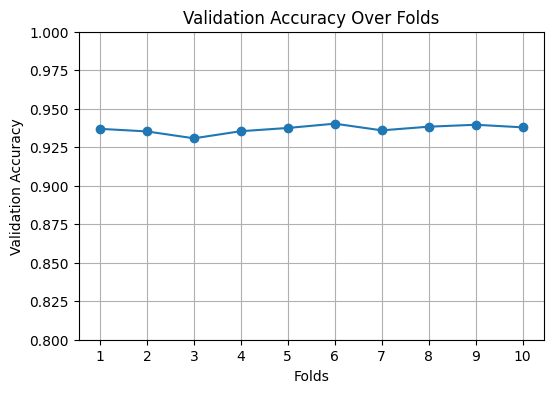

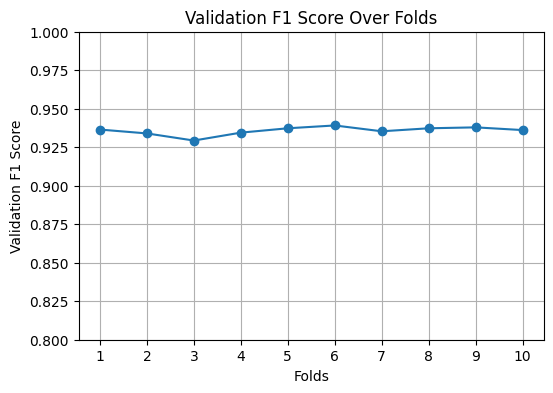

In [48]:
plot_k_folds_metrics(train_loss_history, 'Loss')
plot_k_folds_metrics(train_accuracies, 'Accuracy')
plot_train_f1_score(train_f1_scores, K_FOLDS, 'F1 Score')

plot_validation_graphs(val_accuracies, K_FOLDS, 'Accuracy')
plot_validation_graphs(val_f1_scores, K_FOLDS, 'F1 Score')